In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score

from catboost import CatBoostClassifier

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/MLOps/heart_cleveland_upload.csv')
df.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [4]:
Y = df['condition']
df = df.drop('condition', axis=1)

Отделим численные признаки от категориальных и построим распределения для этих признаков

In [5]:
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_features = list(set(df.columns) - set(numerical_features))

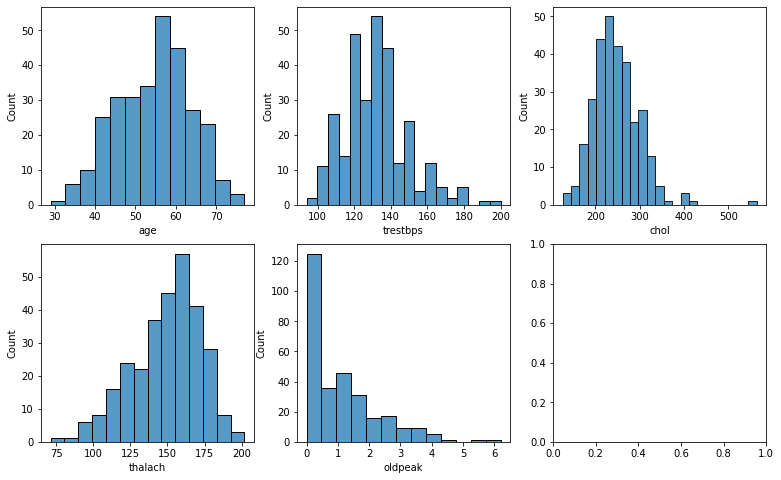

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(13, 8))

ax_array = [axis for row in ax for axis in row] 

for axis, feature in zip(ax_array, numerical_features):
    sns.histplot(df[feature], ax=axis);

Удалим небольшие выбросы

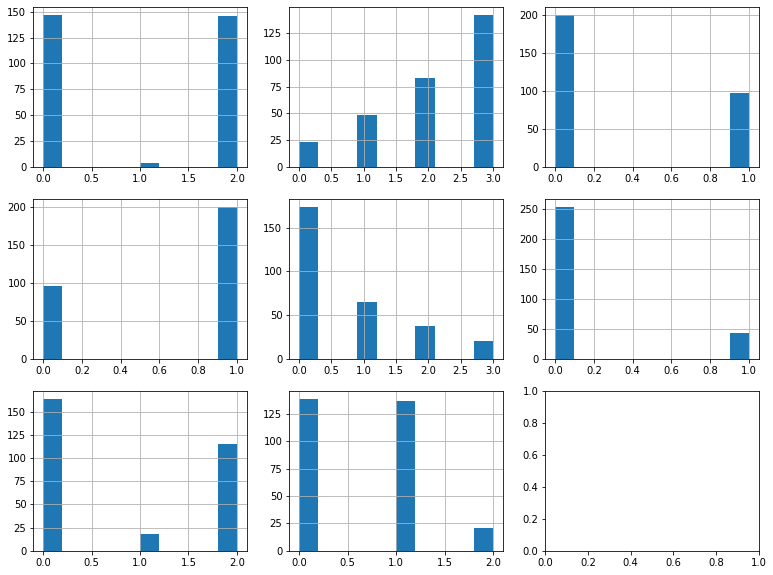

In [7]:
fig, ax = plt.subplots(3, 3, figsize=(13, 10))

ax_array = [axis for row in ax for axis in row] 

for axis, feature in zip(ax_array, categorical_features):
    df[feature].hist(ax=axis)

In [8]:
for feature in categorical_features:
    df = pd.concat([df, pd.get_dummies(df[feature], prefix=feature)], 
                   axis=1, ignore_index=False)

df = df.drop(columns=categorical_features)

Проверим корреляциию признаков с метками

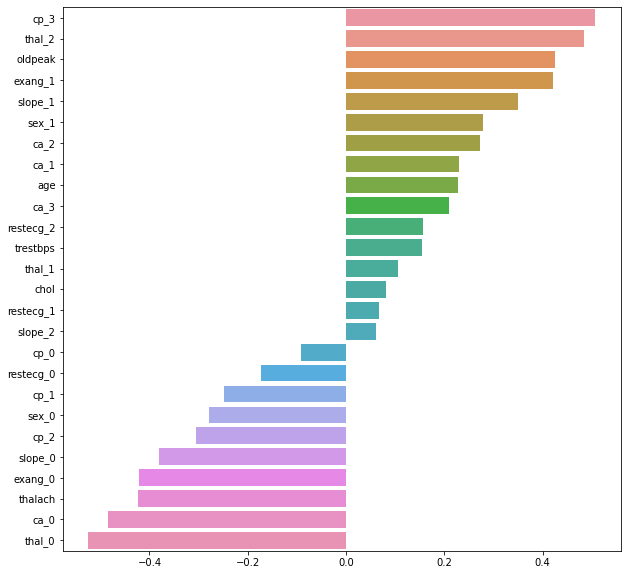

In [19]:
correlations = df.corrwith(Y).sort_values(ascending=False)
plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(10, 10)

Удалим признаки с небольшой корреляцией

In [10]:
df = df.drop(['fbs_0', 'fbs_1'], axis=1)



Отмасштабируем данные и добавим признаки с помощью полиномов 2-го порядка


In [44]:
X = df.to_numpy()
y = Y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [45]:
scaler = Pipeline([
    ('scaler_1', RobustScaler()),
    ('scaler_2', PolynomialFeatures(degree=2))
])

In [46]:
X_train_scal = scaler.fit_transform(X_train)
X_test_scal = scaler.fit_transform(X_test)

Обучим

In [47]:
model = CatBoostClassifier(n_estimators=100, random_state=24, reg_lambda=25)
model.fit(X_train_scal, y_train)

0:	learn: 0.6819232	total: 14.6ms	remaining: 1.45s
1:	learn: 0.6737972	total: 28.3ms	remaining: 1.39s
2:	learn: 0.6658571	total: 41.7ms	remaining: 1.35s
3:	learn: 0.6554330	total: 55.1ms	remaining: 1.32s
4:	learn: 0.6462121	total: 69.2ms	remaining: 1.31s
5:	learn: 0.6365593	total: 82.9ms	remaining: 1.3s
6:	learn: 0.6272921	total: 97.2ms	remaining: 1.29s
7:	learn: 0.6195807	total: 111ms	remaining: 1.28s
8:	learn: 0.6123447	total: 126ms	remaining: 1.27s
9:	learn: 0.6042522	total: 139ms	remaining: 1.25s
10:	learn: 0.5977724	total: 154ms	remaining: 1.25s
11:	learn: 0.5894926	total: 168ms	remaining: 1.23s
12:	learn: 0.5824102	total: 182ms	remaining: 1.22s
13:	learn: 0.5764629	total: 196ms	remaining: 1.2s
14:	learn: 0.5719418	total: 210ms	remaining: 1.19s
15:	learn: 0.5642570	total: 228ms	remaining: 1.2s
16:	learn: 0.5570540	total: 242ms	remaining: 1.18s
17:	learn: 0.5522654	total: 256ms	remaining: 1.17s
18:	learn: 0.5451750	total: 280ms	remaining: 1.19s
19:	learn: 0.5399357	total: 302ms	rem

In [48]:
accuracy_score(y_test, model.predict(X_test_scal))

0.9066666666666666

In [49]:
accuracy_score(y_train, model.predict(X_train_scal))

0.9099099099099099